Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Rita González Márquez

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
# import packages here
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jupyter_black

jupyter_black.load()

## Context
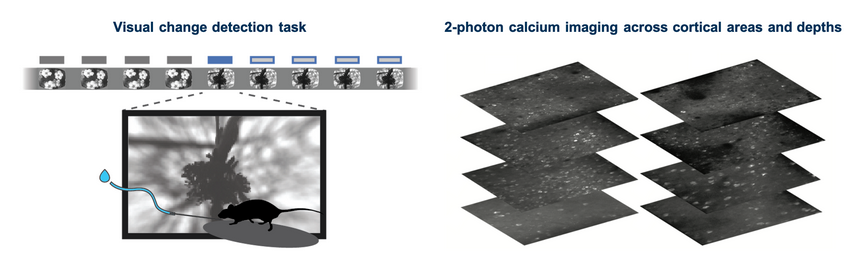

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

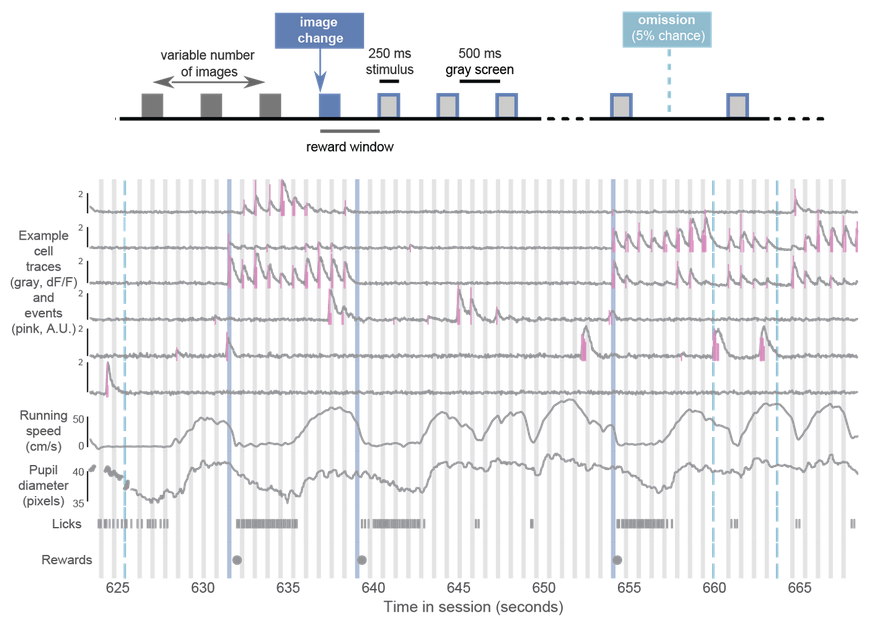

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(
        data, "stim_epoch_table", ["stimulus", "start", "end"]
    )  # NOTE had to rearrange this, as the original order was wrong

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



# 1. Data Exploration

In [3]:
t = data["t"]
dff = data["dff"]
stim_table = data["stim_table"]
stim = data["stim"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = np.nan_to_num(data["running_speed"][0], nan=0)
stim_epoch_table = data["stim_epoch_table"]
experiment_start = stim_epoch_table["start"][0]
print("Experiment start:", experiment_start)

Experiment start: 737


In [4]:
# TODO insert exploration code and plots here!

In [5]:
# we checked the data and found that the difference between the time points is not constant and varies by a small amount # TODO justify!
fs = 1 / np.mean(np.diff(t))  # sampling frequency
dt = 1 / fs  # time step

print(f"Sampling frequency is {fs} Hz, Time Interval is {dt} s")

Sampling frequency is 30.144897456157484 Hz, Time Interval is 0.03317311002481905 s


# 2. Preprocessing

TODO add text here!

## 2.1 Filtering

TODO add text here!

In [6]:
# butterworth filter
low = 0.3 / (fs / 2)
high = 3 / (fs / 2)

# create abs(dff)
# dff_abs[dff_abs < 0] = 0  # = np.abs(dff)

dff_butter = utils.butter_filter_signal(
    x=dff, low=low, high=high, fs=fs, order=4
)  # TODO play with parameters, ich weiß nicht mehr was die bedeuten

# as butterworth filter introduces negative values, we need to set them to zero
dff_butter[dff_butter < 0] = 0

# wiener filter
window_wiener = 15  # TODO sollten wir hier eine windows size nehmen, die einer spike dauer entspricht?
dff_wiener = utils.wiener_filter_signal(x=dff, window=window_wiener)

# both filters applied sequentially
dff_both = utils.wiener_filter_signal(x=dff_butter, window=window_wiener)

/home/steph/miniconda3/envs/NDS/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/steph/miniconda3/envs/NDS/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


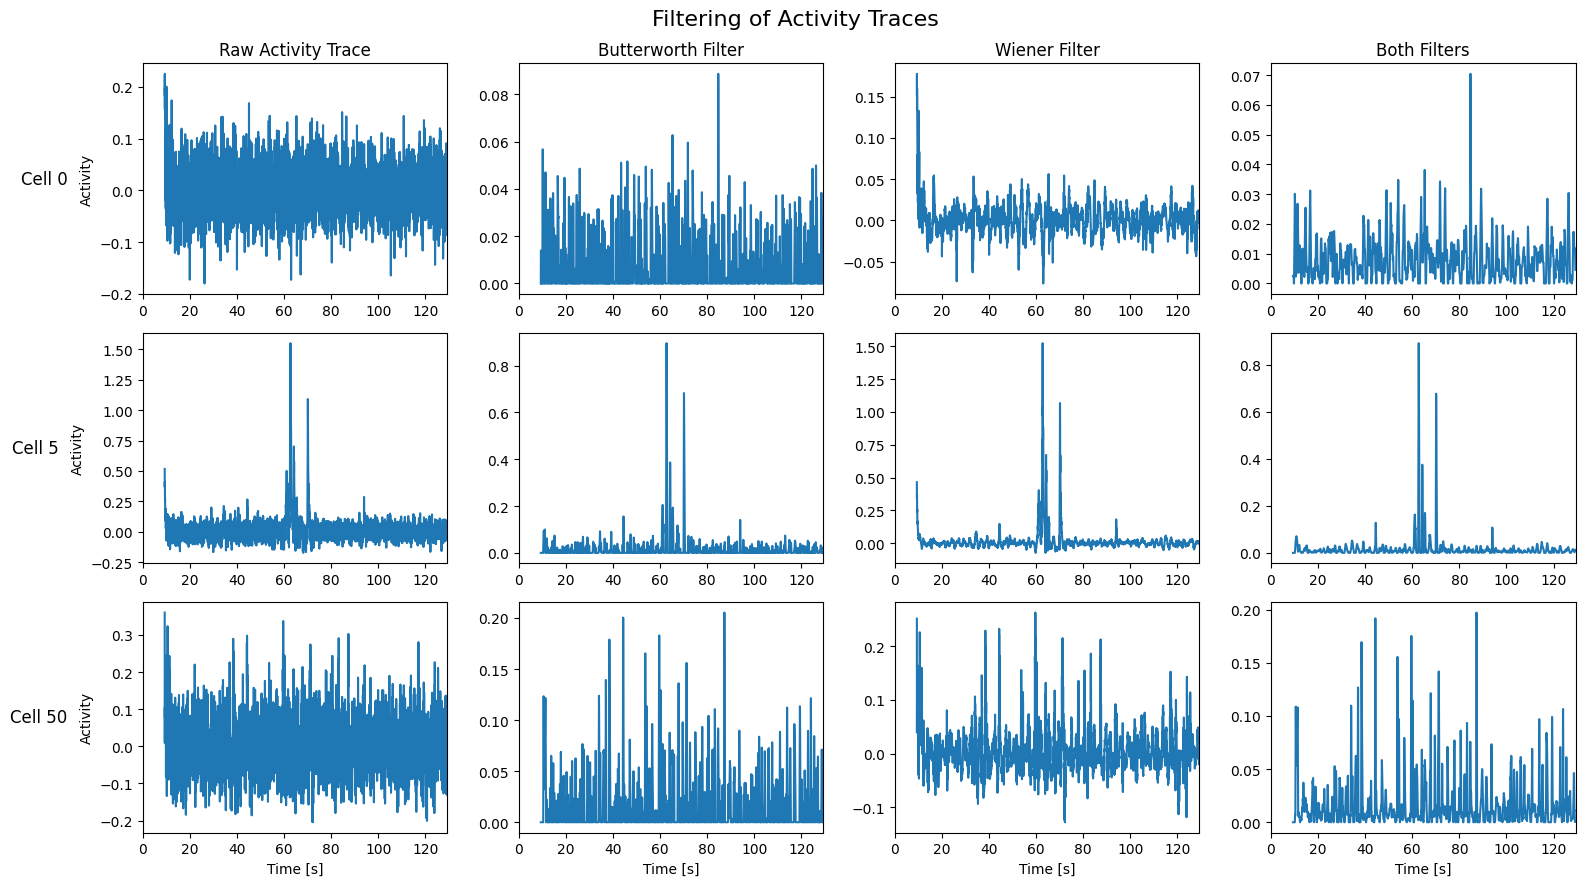

In [7]:
# plot the results for some cells
cell_idxs = [0, 5, 50]
# start and end index for time frame to show
tMin = 0
tMax = int(120 / dt)  # len(t)

column_title = [
    "Raw Activity Trace",
    "Butterworth Filter",
    "Wiener Filter",
    "Both Filters",
]
row_title = [f"Cell {i}" for i in cell_idxs]

fig, axs = plt.subplots(
    len(cell_idxs), 4, figsize=(16, len(cell_idxs) * 3), tight_layout=True
)
for i, cIdx in enumerate(cell_idxs):
    axs[i, 0].plot(t[tMin:tMax], dff[cIdx][tMin:tMax])  # raw data
    axs[i, 1].plot(t[tMin:tMax], dff_butter[cIdx][tMin:tMax])  # butterworth
    axs[i, 2].plot(t[tMin:tMax], dff_wiener[cIdx][tMin:tMax])  # wiener
    axs[i, 3].plot(t[tMin:tMax], dff_both[cIdx][tMin:tMax])  # both

    axs[i, 0].set_ylabel("Activity")

for col in range(4):
    axs[0, col].set_title(column_title[col])
    axs[len(cell_idxs) - 1, col].set_xlabel("Time [s]")

for ax, row in zip(axs[:, 0], row_title):
    ax.annotate(
        row,
        (0, 0.5),
        xytext=(-ax.yaxis.labelpad - 5, 0),
        xycoords=ax.yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        size="large",
    )

for ax in axs.flatten():
    ax.set_xlim(-dt, t[tMax] + dt)

fig.suptitle("Filtering of Activity Traces", fontsize=16)
fig.subplots_adjust(left=0.15, right=0.9, top=0.95)
plt.show()

TODO Conclusion?

## 2.2 Smoothing? wollten wir da noch was machen?

## 2.3 Deconvolution

TODO Text

In [8]:
# deconvolution using oopsi
oopsi_thresh = 0.045  # TODO adaptive thresholding?

# this runs for a while. You can load the results from file in the cell below instead.
# If you want to run it, set from_file=False
from_file = True
deconv_oopsi = {}
if not from_file:
    deconv_oopsi = utils.oopsi_inference(
        dff=dff_wiener, dt=dt, thresh=oopsi_thresh, to_file=True
    )
else:
    deconv_oopsi = utils.load_inferred_spikes("../data/inference_oopsi.pkl")

for k in deconv_oopsi.keys():
    print(f"Key: {k}, Shape: {deconv_oopsi[k].shape}")

# TODO other deconvolution methods...

Key: spikes, Shape: (189, 105968)
Key: deconv, Shape: (189, 105968)
Key: infspikes, Shape: (189, 105968)


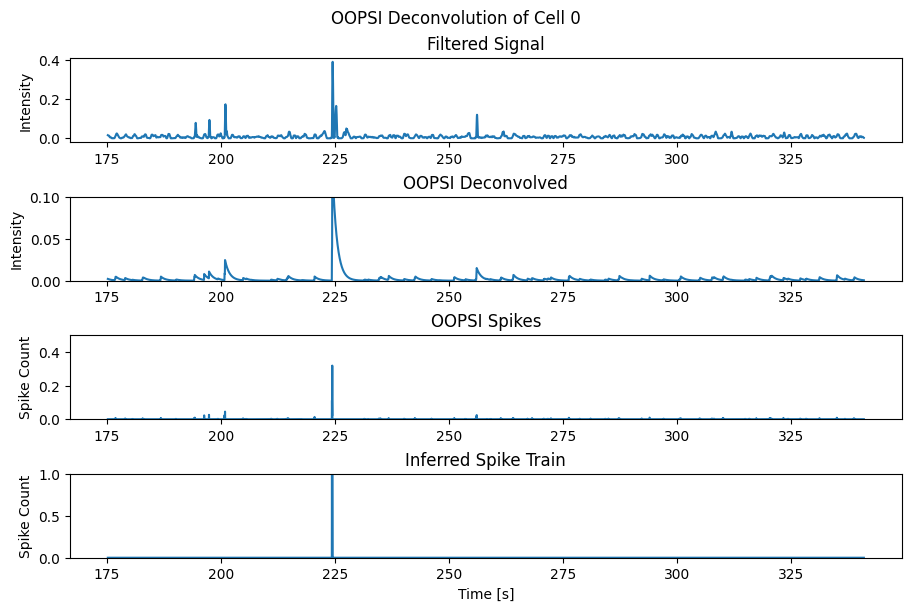

In [9]:
# plot the results for a cell
start = 5000
end = 10000
cell_idx = 0

fig, axs = plt.subplots(4, 1, figsize=(9, 6), layout="constrained")
axs[0].plot(t[start:end], dff_both[cell_idx][start:end])
axs[0].set_title("Filtered Signal")
axs[0].set_ylabel("Intensity")

axs[1].plot(t[start:end], deconv_oopsi["deconv"][cell_idx, start:end])
axs[1].set_title("OOPSI Deconvolved")
axs[1].set_ylim(0, 0.1)
axs[1].set_ylabel("Intensity")

axs[2].plot(t[start:end], deconv_oopsi["spikes"][cell_idx, start:end])
axs[2].set_title("OOPSI Spikes")
axs[2].set_ylim(0, 0.5)
axs[2].set_ylabel("Spike Count")

axs[3].plot(t[start:end], deconv_oopsi["infspikes"][cell_idx, start:end])
axs[3].set_title("Inferred Spike Train")
axs[3].set_ylim(0, 1)
axs[3].set_ylabel("Spike Count")


plt.xlabel("Time [s]")
plt.suptitle(f"OOPSI Deconvolution of Cell {cell_idx}")

plt.show()

## 2.4 Intermediate Analysis

TODO Text!

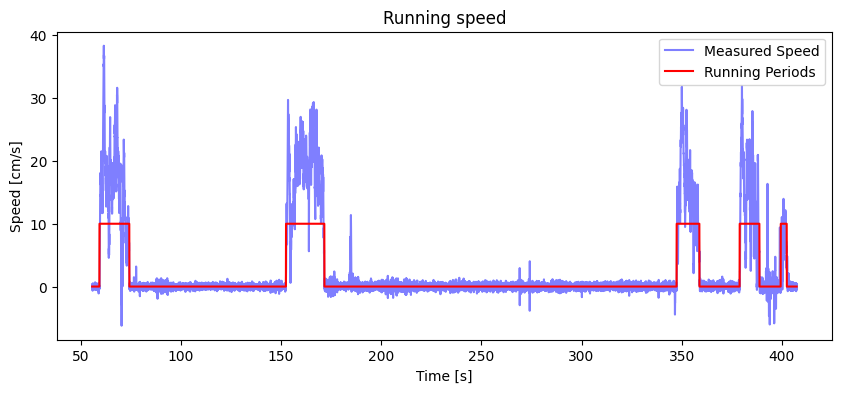

In [10]:
# we filter the running speed signal
running_periods = utils.filter_running_speed(running_speed)

start = 1400
end = 12000

fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.plot(
    t[start:end],
    running_speed[start:end],
    color="blue",
    label="Measured Speed",
    alpha=0.5,
)
axs.plot(
    t[start:end], running_periods[start:end] * 10, color="red", label="Running Periods"
)
axs.set_title("Running speed")
axs.set_xlabel("Time [s]")
axs.set_ylabel("Speed [cm/s]")
plt.legend()
plt.show()

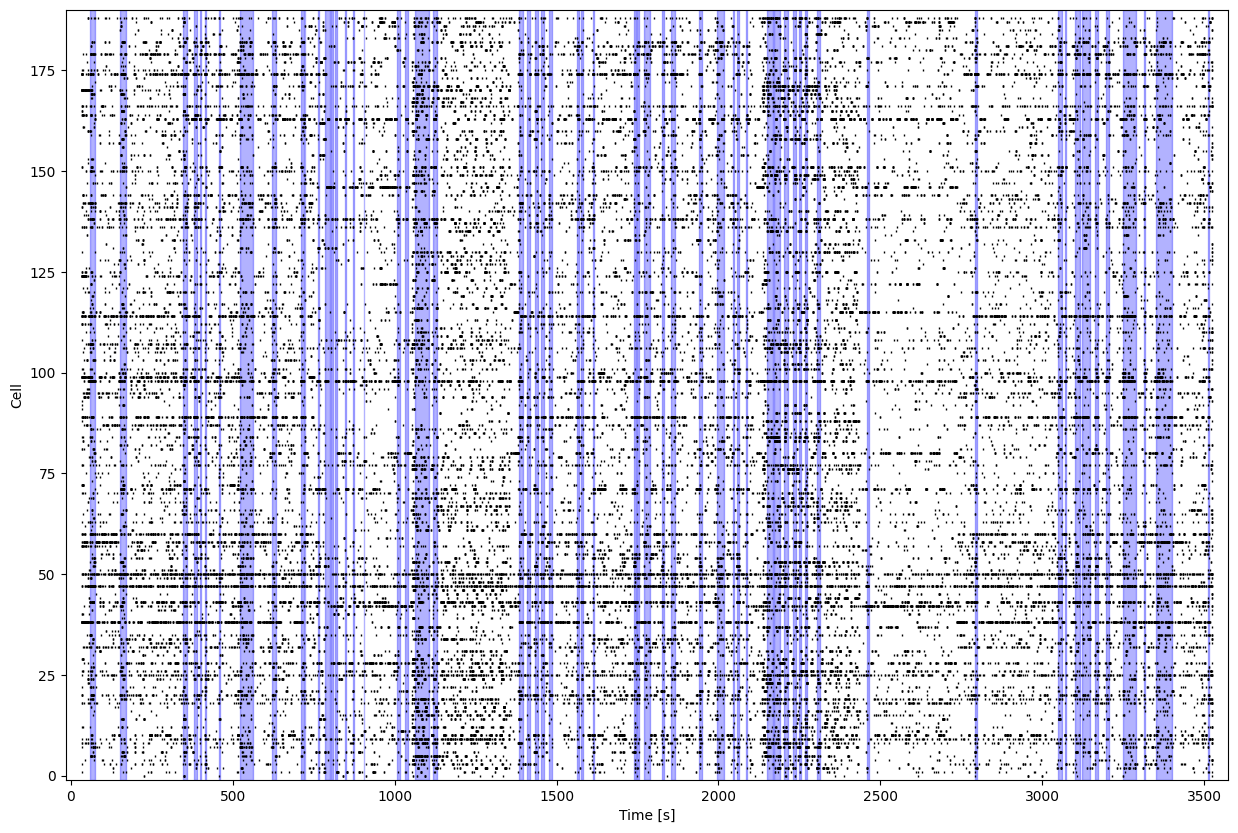

In [11]:
# plot the detected spikes per cell and running speed
start = experiment_start
end = len(t) - 1
show_epochs = False
show_running = True

fig, axs = plt.subplots(figsize=(15, 10))
for cellIdx in range(dff.shape[0]):
    spike_train_cell = deconv_oopsi["infspikes"][cellIdx, :]
    # create binary array for spikes and no spikes in spike train
    spike_binary = np.ones_like(spike_train_cell) * -50
    spike_binary[spike_train_cell == 1] = cellIdx
    axs.plot(
        t[start:end],
        spike_binary[start:end],
        marker="|",
        linestyle="None",
        color="k",
        markersize=2,
    )

# mark the epochs where the locally sparse noise stimulus is not shown
other_stimuli = utils.get_epochs_in_range(stim_epoch_table, start, end)
if show_epochs and not other_stimuli.empty:
    for i in range(other_stimuli.shape[0]):
        ep_start = other_stimuli.iloc[i]["start"]
        ep_end = other_stimuli.iloc[i]["end"]
        if i == 0:
            axs.axvspan(
                t[ep_start], t[ep_end], color="gray", alpha=0.2, label="Other Stimulus"
            )
        else:
            axs.axvspan(t[ep_start], t[ep_end], color="gray", alpha=0.2)

# mark the running periods with a red line
running_epochs = utils.get_epochs_in_range(
    utils.get_running_periods_table(running_periods), start, end
)
running_epochs = running_epochs[running_epochs["stimulus"] == "running"]
if show_running and not running_epochs.empty:
    for i in range(running_epochs.shape[0]):
        r_start = running_epochs.iloc[i]["start"]
        r_end = running_epochs.iloc[i]["end"]
        if i == 0:
            axs.axvspan(
                t[r_start], t[r_end], color="blue", alpha=0.3, label="Running Period"
            )
        else:
            axs.axvspan(t[r_start], t[r_end], color="blue", alpha=0.3)

axs.set_xlim(t[start] - 50, t[end] + 50)
axs.set_ylim(-1, dff.shape[0] + 1)
axs.set_xlabel("Time [s]")
axs.set_ylabel("Cell")
# if not running_epochs.empty or not other_stimuli.empty:
#     plt.legend()
plt.show()

In [12]:
# TODO running periods correlieren lassen
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.stats.multitest as smm


# Function to analyze spike and running period correlation
def analyze_spike_running_correlation(spiketrains, running_period):
    n_cells, n_measurements = spiketrains.shape

    # Ensure running_period is boolean
    running_period = running_period.astype(bool)

    # Initialize lists to store results
    p_values = []

    # Iterate over each cell to perform the statistical test
    for cell in range(n_cells):
        # Get spikes for running and non-running periods
        spikes_running = spiketrains[cell, running_period]
        spikes_non_running = spiketrains[cell, ~running_period]

        # Calculate the average spike rate during running and non-running periods
        rate_running = np.mean(spikes_running)
        rate_non_running = np.mean(spikes_non_running)

        # Perform unpaired statistical test
        if np.var(spikes_running) == 0 or np.var(spikes_non_running) == 0:
            # If there's no variation, set p-value to 1.0
            p_value = 1.0
        else:
            # Use independent t-test or Mann-Whitney U test
            t_stat, p_value = ttest_ind(
                spikes_running, spikes_non_running, equal_var=False
            )

        p_values.append(p_value)

    # Apply multiple comparisons correction (Bonferroni)
    corrected_p_values = smm.multipletests(p_values, method="bonferroni")[1]

    # Identify significant cells
    significant_cells = np.where(corrected_p_values < 0.05)[0]

    return significant_cells, corrected_p_values


assert running_periods.shape[0] == deconv_oopsi["infspikes"].shape[1]
analyze_spike_running_correlation(deconv_oopsi["infspikes"], running_periods)

(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  15,
         16,  17,  19,  20,  21,  22,  23,  24,  25,  27,  28,  30,  33,
         34,  35,  36,  37,  38,  41,  42,  43,  47,  49,  50,  52,  53,
         54,  55,  56,  57,  58,  60,  62,  64,  65,  67,  70,  71,  73,
         74,  76,  77,  80,  81,  83,  84,  86,  87,  88,  89,  90,  92,
         94,  95,  96,  98,  99, 100, 101, 102, 103, 105, 106, 107, 110,
        111, 112, 113, 114, 115, 116, 117, 119, 120, 130, 131, 132, 134,
        135, 136, 137, 138, 139, 141, 142, 145, 149, 150, 151, 153, 155,
        157, 158, 159, 161, 163, 164, 165, 166, 168, 169, 171, 172, 174,
        175, 178, 179, 180, 182, 183, 184, 187, 188]),
 array([1.00000000e+000, 1.00000000e+000, 4.11961260e-012, 4.59994351e-002,
        2.20496077e-002, 3.02984000e-033, 2.11249010e-028, 3.90191460e-035,
        1.84568461e-014, 1.66342559e-002, 2.68190332e-011, 6.78815159e-008,
        8.47300660e-003, 7.63007601e-001, 2.62763306e-014, 1

## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

## Receptive Field Estimation

In [13]:
from rfest.utils import upsample_data

stim_table = data["stim_table"]
stim = data["stim"]
Xup, y, dt = upsample_data(
    stim, np.array(stim_table["start"].tolist()) / 100, deconv_oopsi["spikes"][0], t
)
# TODO: ggf spikes rauswerfen und time neu indexen...

In [14]:
stim.shape

(9000, 16, 28)

In [15]:
from rfest.utils import build_design_matrix

dims = [25, 16, 28]  # sind unsere stimulus dimensionen (25 ist anzahl neurone?)
Xdsgn = build_design_matrix(Xup, 25)

In [16]:
Xdsgn.shape

(31594, 11200)

In [17]:
def compute_STA(X, y, dims):

    if len(X.shape) == 1:
        X = X[:, None]

    if len(y.shape) == 1:
        y = y[:, None]

    n_spikes = np.sum(y)
    w_STA = X.T @ y / n_spikes

    return w_STA.reshape(dims)


w_sta_3d = compute_STA(Xdsgn, y, dims)

In [18]:
from scipy.ndimage import gaussian_filter

w_sta_3d_smoothed = np.dstack(
    [gaussian_filter(w_sta_3d[i], 1).T for i in range(len(w_sta_3d))]
).T

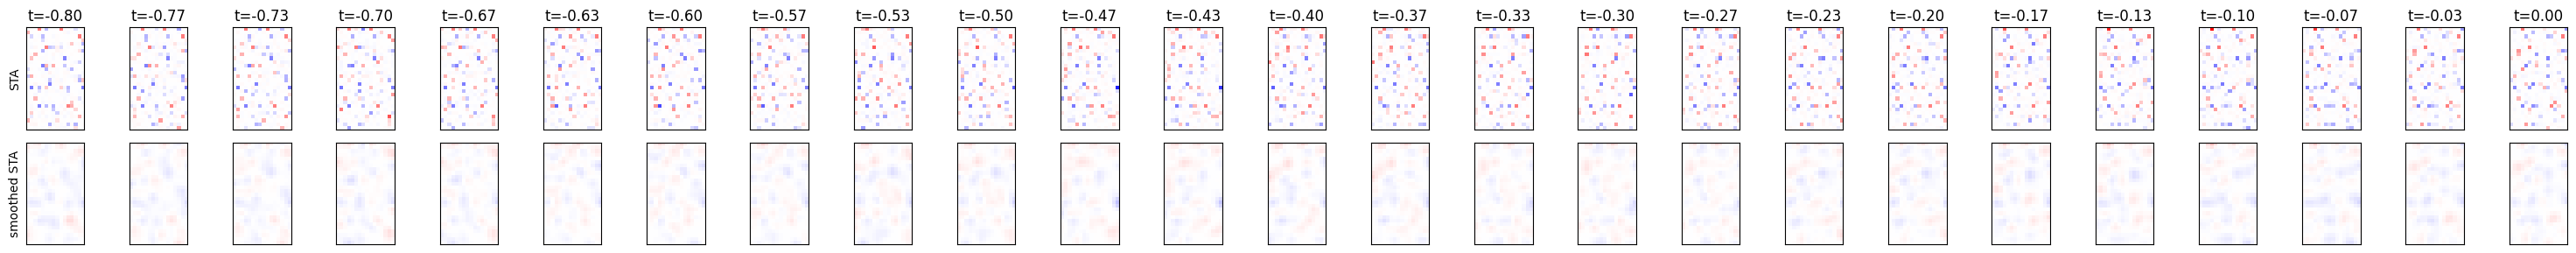

In [19]:
tt = np.linspace(-0.8, 0, 25)
vmax = np.max([np.abs(w_sta_3d.min()), w_sta_3d.max()])

fig, ax = plt.subplots(2, 25, figsize=(30, 3))
for i in range(25):
    ax[0, i].imshow(w_sta_3d[i].T, cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax)
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[0, i].set_title(f"t={tt[i]:.02f}")
    if i == 0:
        ax[0, i].set_ylabel("STA")

from scipy.ndimage import gaussian_filter

for i in range(25):
    ax[1, i].imshow(w_sta_3d_smoothed[i].T, cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    if i == 0:
        ax[1, i].set_ylabel("smoothed STA")

fig.tight_layout()

In [20]:
def animate(
    data,
    dt=0.033,
    reverse=False,
    cmap=plt.cm.bwr,
    vmin=-0.2,
    vmax=0.2,
    save_to=False,
    figsize=(6, 6),
):
    """
    Helper function for turning a stimulus into a video
    """

    from IPython.display import HTML
    import matplotlib.animation as animation

    dims = data.shape
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    n_samples = data.shape[0]
    im = ax.imshow(data[0, :, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
    if reverse:
        tt = -np.arange(0, n_samples, 1)[::-1] * dt
    else:
        tt = np.arange(0, n_samples, 1) * dt
    ax.set_title(f"t={tt[0]:.02f} s")
    ax.set_xticks([])
    ax.set_yticks([])

    def init():
        im.set_data(data[0, :, :].T)
        return im

    # animation function. This is called sequentially
    def animate(j):
        data_slice = data[j, :, :].T
        ax.set_title(f"t={tt[j]:.02f} s")
        im.set_data(data_slice)

        return im

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=dims[0], interval=dt * 1000, blit=False
    )
    if save_to is not False:
        Writer = animation.writers["ffmpeg"]
        writer = Writer(fps=1 / dt, metadata=dict(artist="Me"), bitrate=1800)
        anim.save(save_to, writer=writer)
    plt.close()
    return HTML(anim.to_html5_video())

In [21]:
vmax = np.max([np.abs(w_sta_3d.min()), w_sta_3d.max()])

animate(w_sta_3d, dt=0.25, vmax=vmax, vmin=-vmax, reverse=True)

In [22]:
vmax = np.max([np.abs(w_sta_3d_smoothed.min()), w_sta_3d_smoothed.max()])

animate(w_sta_3d_smoothed, dt=0.25, vmax=vmax, vmin=-vmax, reverse=True)

In [23]:
from rfest.utils import split_data

# here we also smooth the signal a little bit
(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(
    Xup,
    gaussian_filter(y, sigma=2, truncate=0.25),
    dt,
    frac_train=0.95,
    frac_dev=0.05,
    verbose=1,
)

SUMMARY
               N    Minutes   Fraction
Total      31594      17.47        1.0
Train      30006      16.59       0.95
Dev         1574       0.87       0.05
Test          14        0.0        0.0


In [24]:
from rfest import GLM

# For Ca2+ data, I personally prefer Linear-Gaussian model. 
# you can, of course, also use Poisson model with the positive gradient of the ca2+...


df = [7, 9, 7] # degree of freedom, you need to tune this hyperparmeter for your data

m = GLM(distr='gaussian', output_nonlinearity='none')
m.add_design_matrix(X_train, dims=dims, df=df, smooth='cr', filter_nonlinearity='none', name='stimulus') # light stimulus
m.add_design_matrix(X_dev, dims=dims, name='stimulus', kind='dev')
m.initialize({'train': y_train, 'dev': y_dev}, num_subunits=1, dt=dt, method='mle', random_seed=2046)